# DAAO venues and organisations

This is an exploratory data analysis of collected data from [DAAO](https://www.daao.org.au/). We focus on venues and organisations adopting natural language processing to reveal patterns in the data.

The visualisations consist of...
- word clouds
- dendrograms
- time series and temporal bar charts

In [20]:
import pandas as pd
import numpy as np
import json
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go

# with open("./daao_venue_level.json") as json_file: daoo_venue_data=json.load(json_file)
with open("data/daao_event_level.json") as json_file: daoo_event_data=json.load(json_file)

# find all events with geolocation
daoo_event_data_geolocated=[coverage_event for coverage_event in [event for event in daoo_event_data if 'coverages' in event] if 'place' in coverage_event['coverages'][0]]

# find all geoloacted events with date
daoo_event_data_geolocated_dates=[event for event in daoo_event_data_geolocated if 'date_range' in event['coverages'][0]]

# 
relevenat_daoo_event_data=[]
for geolocated_event_date in daoo_event_data_geolocated_dates:
    try:
        relevenat_daoo_event_data.append({
            "id":geolocated_event_date['_id']['$oid'],
            'title':geolocated_event_date['title'],
            'start_date':geolocated_event_date['coverages'][0]['date_range']['start']['_date'],
            "end_date":geolocated_event_date['coverages'][0]['date_range']['end']['_date'],
            "place_name":geolocated_event_date['coverages'][0]['place'][0]['address'],
            'latitude':geolocated_event_date['coverages'][0]['place'][0]['centroid']['latitude'],
            'longitude':geolocated_event_date['coverages'][0]['place'][0]['centroid']['longitude'],
            'slug':geolocated_event_date['slug'],
            'description':geolocated_event_date['description']
            # 'type_slug':geolocated_event_date['types'][0]['slug']
        })
    except:
        continue

# len(daoo_event_data_geolocated), len(daoo_event_data_geolocated_dates), len(relevenat_daoo_event_data)

df_daoo_relevant_events=pd.DataFrame(relevenat_daoo_event_data)
df_daoo_relevant_events['start_year']=[int(start_date.split('-')[0]) for start_date in df_daoo_relevant_events['start_date']]
df_daoo_relevant_events['end_year']=[int(end_date.split('-')[0]) for end_date in df_daoo_relevant_events['end_date']]
df_daoo_relevant_events=df_daoo_relevant_events[df_daoo_relevant_events['start_year'].between(1900,2020)]
# df_daoo_relevant_events=df_daoo_relevant_events[df_daoo_relevant_events['type_slug'].isin(["exhibition",'festival','performance-event','other-event'])]
# df_slug_freq=pd.DataFrame(dict(Counter(df_daoo_relevant_events["type_slug"])).items(),columns=["Slug","Frequency"])

## Most frequent geocodes

Before jumping into the visuals, we inspect the nuances of the geocodes attached to exhibtion data. We find that the geocodes are not always accurate, and that there are many distinct venues representing the same geocode. Further pre-processing will need to be conducted to ensure downstream trends can be accurately identified. 

Below is a list of the top 20 geocodes, and the number of events they represent. Through further inspection we can see which geocodes accurate represent the place names.

In [36]:
most_freq_geocodes = df_daoo_relevant_events[['latitude','longitude']].value_counts().reset_index().rename(columns={0:'Frequency'})
most_freq_geocodes.head(20)

,latitude,longitude,Frequency
0,-33.868901,151.207091,1973
1,-34.928621,138.599959,1066
2,-37.813187,144.962980,1003
3,-27.470933,153.023502,868
4,-33.868627,151.217062,459
5,-34.416667,150.883333,218
6,-37.822536,144.969113,215
7,-31.952222,115.858889,205
8,-27.472096,153.018173,168
9,-12.437368,130.833821,160


### 590 places with random Sydney location

In [37]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[0]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[0])]['place_name']\
                        .value_counts()

Sydney, NSW                                 248
Artspace, Sydney, NSW                        97
Macquarie Galleries, Sydney, NSW             64
Sherman Galleries, Sydney, NSW               56
Sydney, New South Wales                      54
                                           ... 
Rex Livingston Art Dealer, Sydney, NSW        1
Bondi coastal walk, Sydney, NSW               1
Sherman Galleries Goodhope, Sydney            1
Sherman Galleries Hargrave, Sydney, NSW       1
Watters Gallery, Sydney, New South Wales      1
Name: place_name, Length: 590, dtype: int64

### 116 places with random Adelaide location

In [38]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[1]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[1])]['place_name']\
                        .value_counts()

Experimental Art Foundation, Adelaide, SA                   430
Contemporary Art Centre of South Australia, Adelaide, SA    346
Adelaide, SA                                                 36
Adelaide Central Gallery, Adelaide, SA                       36
Greenaway Art Gallery, Adelaide, SA                          31
                                                           ... 
SA Museum, Adelaide, SA                                       1
BMGArt, Adelaide, SA                                          1
Peel Street Art Gallery, Adelaide, SA                         1
Royal Society of Arts Gallery, Adelaide, SA                   1
Adelaide                                                      1
Name: place_name, Length: 116, dtype: int64

### 411 places with random Melbourne location

In [39]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[2]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[2])]['place_name']\
                        .value_counts()

Melbourne, Vic.                                                 75
Monash University Museum of Art, Melbourne, VIC                 39
RMIT Gallery, Melbourne, VIC                                    37
Australian Centre for Contemporary Art, Melbourne, VIC          33
Melbourne, Victoria                                             29
                                                                ..
Ardwolf Gallery, Melbourne, Vic.                                 1
First Floor Gallery, Melbourne, Vic.                             1
ANZ Building, Melbourne, Vic.                                    1
Studio 12, Gertrude Contemporary Art Spaces, Melbourne, Vic.     1
Riddell Galleries, Melbourne, Vic.                               1
Name: place_name, Length: 411, dtype: int64

### 240 places with random Brisbane location

In [40]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[3]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[3])]['place_name']\
                        .value_counts()

Institute of Modern Art, Brisbane, QLD                                       217
Brisbane, Qld                                                                 95
Brisbane City Art Gallery, Brisbane, Qld                                      68
Brisbane, QLD                                                                 32
Brisbane, Queensland                                                          21
                                                                            ... 
Finney's Auditoium, Brisbane, QLD                                              1
Contemporary Art Society of Australia ( Queensland Branch), Brisbane, QLD      1
Finney's Auditorium, Brisbane, QLD                                             1
Eager's Retail Pty Ltd, Brisbane, QLD                                          1
QUT Art Museum, Brisbane, QLD                                                  1
Name: place_name, Length: 240, dtype: int64

### Art Gallery of New South Wales, Sydney, NSW - 520 events

In [41]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[4]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[4])]['place_name']\
                        .value_counts()

Art Gallery of New South Wales, Sydney, NSW                                      397
Art Gallery of NSW, Sydney, NSW                                                   24
National Art Gallery of New South Wales, Sydney, NSW                               6
Art Gallery Of New South Wales, Sydney, NSW                                        4
[National] Art Gallery of New South Wales, Sydney, New South Wales                 4
Art Gallery of New South Wales, Sydney, New South Wales                            3
[National] Art Gallery of New South Wales, Sydney, NSW                             3
Art Gallery New South Wales, Sydney, NSW                                           2
Art Gallery of NSW                                                                 2
Art Gallery of NSW, Sydney, Australia.                                             1
Art Gallery of New South Wales                                                     1
Art Gallery of  New South Wales, Sydney, NSW                     

### Wollongong City Gallery - 218 events

In [42]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[5]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[5])]['place_name']\
                        .value_counts()

Wollongong City Gallery, Wollongong, NSW                                                                                 178
Wollongong City Art Gallery, Wollongong, NSW                                                                               9
Project Centre for Contemporary Art, Wollongong, NSW                                                                       5
Wollongong City Gallery, NSW                                                                                               4
Wollongong, NSW                                                                                                            2
Wollongong City Art Gallery, Wollongong, New South Wales                                                                   2
Wollongong Art Gallery, Wollongong, NSW                                                                                    2
Wollongong Regional Gallery, NSW                                                                                           2


### National Gallery of Victoria, Melbourne, VIC - 215 events

In [43]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[6]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[6])]['place_name']\
                        .value_counts()

National Gallery of Victoria, Melbourne, VIC                                                         119
National Gallery of Victoria, Melbourne, Vic.                                                         65
Ian Potter Centre, National Gallery of Victoria, Melbourne, VIC                                       11
National Gallery of Victoria, Melbourne, Victoria                                                      4
Access Gallery, National Gallery of Victoria, Melbourne, Vic.                                          3
Ian Potter Centre, National Gallery of Victoria, Melbourne, Vic.                                       3
National Gallery of Victoria, Vic.                                                                     1
National Gallery of Victoria, Melbourne                                                                1
National Gallery of Victoria, Melbourne, Vic; Bonython Gallery, Sydney, NSW                            1
Dusseldorf, Germany; London, UK; Humleaek, Denmark; Nat

### 55 places with random Perth location

In [44]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[7]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[7])]['place_name']\
                        .value_counts()

Perth, WA                                                                      51
John Curtin Gallery, Curtin University, Perth, WA                              42
Perth Institute of Contemporary Art, Perth, WA                                 13
Greenhill Galleries, Perth, WA                                                  8
Perth Institute of Contemporary Arts, Perth, WA                                 7
Galerie Dusseldorf, Perth, WA                                                   6
Katanning Arts Centre, Katanning & Western Australian Museum, Perth, WA         5
Goddard de Fiddes Gallery, Perth, WA                                            4
Emerge Art Space, Perth, WA                                                     4
Turner Galleries, Perth, WA                                                     4
Goddard de Fiddes Contemporary Art, Perth, WA                                   4
John Curtin Gallery, Perth, WA                                                  3
Central TAFE Art

### Queensland Art Gallery, Brisbane, QLD - 168 events

In [45]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[8]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[8])]['place_name']\
                        .value_counts()

Queensland Art Gallery, Brisbane, QLD           113
Queensland Art Gallery, Brisbane, Qld            31
Queensland Art Gallery, Brisbane, Qld.            9
Queensland Art Gallery, Brisbane                  2
Queensland Art Gallery, South Brisbane, QLD       2
Queensland Art Gallery, Brisbane. QLD             2
Queensland Art Gallery, Brsbane, QLD              2
Queensland Art Gallery, Brisbane. Qld.            1
Queensland Art Gallery, Brisbane, Queensland      1
Queensland Gallery of Art, Brisbane, Qld          1
Queesland Art Gallery,Brisbane, QLD               1
Quieensland Art Gallery, Brisbane, Qld            1
Queensland Art Gallery, brisbane, QLD             1
Queensland ArtGallery, Brisbane, QLD              1
Name: place_name, dtype: int64

### Museums and Art Galleries of the Northern Territory, Darwin, NT - 160 events

In [46]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[9]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[9])]['place_name']\
                        .value_counts()

Museums and Art Galleries of the Northern Territory, Darwin, NT      122
Museum and Art Gallery of the Northern Territory, Darwin, NT          22
Museum & Art Gallery of the Northern Territory, Darwin, NT             5
Museums and Art Gallery of the Northern Territory, Darwin              2
Museum & Gallery of Northern Territory, Darwin, NT                     2
Museums and Art Galleries of the Northern Territory, Darwin NT.        2
Northern Territory Museums and Art Galleris, Darwin, NT                1
Museum and Art Gallery, Darwin, NT                                     1
Museum and Art Gallery of the Northern Territory , Darwin, NT          1
Museums and Art Galleries of the Northern Territories, Darwin, NT      1
Darwin Museum and Art Gallery, NT                                      1
Name: place_name, dtype: int64

### 65 places with random Canberra location

In [47]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[10]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[10])]['place_name']\
                        .value_counts()

Canberra Contemporary Art Space, Canberra, ACT           20
National Portrait Gallery, Canberra, ACT                 15
Beaver Galleries, Canberra, ACT                          15
Canberra, ACT                                            12
aGOG (australian Girls Own Gallery), Canberra, ACT        6
                                                         ..
australian Girls Own Gallery, Canberra, ACT               1
Crafts Council of Australia, Canberra, ACT                1
ANU Drill Hall Gallery, Canberra ACT                      1
Lanyon homestead, Canberra, ACT                           1
Canberra Contemporary Artspace, Manuka, Canberra, ACT     1
Name: place_name, Length: 65, dtype: int64

### 75 places with random London, UK location

In [48]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[11]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[11])]['place_name']\
                        .value_counts()

London, England, UK                                  30
Burlington House, Piccadilly, London, England, UK    17
London, UK                                            8
London, England                                       5
Primavera, London, UK                                 4
                                                     ..
Transition Gallery, London, UK                        1
Century Gallery, ACAVA Studios, London, UK            1
Jerwood Space, London, UK                             1
Air & Space Studio, London, UK                        1
London                                                1
Name: place_name, Length: 75, dtype: int64

### 54 places with random Paddington, NSW location

In [49]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[12]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[12])]['place_name']\
                        .value_counts()

Ivan Dougherty Gallery, COFA, UNSW, Paddington, NSW                                                        24
Kaliman Gallery, Paddington, Sydney, NSW                                                                   10
Roslyn Oxley9 Gallery, Paddington, Sydney, NSW                                                              9
Mary Place Gallery, Paddington, NSW                                                                         8
Ivan Dougherty Gallery, Paddington, Sydney, NSW                                                             7
Global Gallery, Paddington, NSW                                                                             7
Barry Stern Galleries, Paddington, New South Wales                                                          4
Josef Lebovic Gallery, Paddington, Sydney, NSW                                                              4
Holdsworth Galleries, Paddington, Sydney, NSW                                                               4
Sherman Ga

### National Gallery of Australia, Canberra, ACT - 132 events

In [50]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[13]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[13])]['place_name']\
                        .value_counts()

National Gallery of Australia, Canberra, ACT                                  112
Australian National Gallery, Canberra, ACT                                     10
National Gallery of Australia, Canberra, ACT (and touring)                      3
National Gallery of Australia, Canberra                                         1
National Gallery of Australia, Canberra, ACT, (and touring)                     1
Australian National Gallery, Parkes, ACT                                        1
Marsh Pond, Sculpture Garden, National Gallery of Australia, Canberra, ACT      1
The Drill Hall Gallery, ANU & National Gallery of Australia, Canberra, ACT      1
National Gallery Australia, Canberra, ACT                                       1
National Gallery, Canberra, ACT                                                 1
Name: place_name, dtype: int64

### Newcastle Region Art Gallery, Newcastle, NSW - 125 events

In [51]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[14]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[14])]['place_name']\
                        .value_counts()

Newcastle Region Art Gallery, Newcastle, NSW              101
Newcastle Regional Art Gallery, Newcastle, NSW             14
Newcastle Regional Art Gallery, NSW                         3
Newcastle Region Art Gallery , Newcastle, NSW               1
Newcastle Regional Art Gallery,  Newcastle, NSW             1
Newcastle City Art Gallery, Newcastle, New South Wales      1
Tighes Hill Gallery, Newcastle, NSW                         1
Newcastle Regional Art Gallery, Newscastle, NSW             1
Art Gallery Newcastle, NSW                                  1
Newcastle Region Gallery, Newcastle, NSW                    1
Name: place_name, dtype: int64

### Art Gallery of Western Australia, Perth, WA - 117 events

In [52]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[15]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[15])]['place_name']\
                        .value_counts()

Art Gallery of Western Australia, Perth, WA                  112
Art Gallery of Western Australia, Perth, WA (and touring)      3
Art Gallery of Western Australia, Perth                        1
Western Australian Art Gallery, Perth, WA                      1
Name: place_name, dtype: int64

### Orange Regional Gallery, Orange, NSW - 113 events

In [53]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[16]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[16])]['place_name']\
                        .value_counts()

Orange Regional Gallery, Orange, NSW        100
Orange Regional Art Gallery, Orange, NSW      8
Orange Regional Gallery, NSW                  4
Orange Regional Gallery                       1
Name: place_name, dtype: int64

### 60 places with random Hobart location

In [54]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[17]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[17])]['place_name']\
                        .value_counts()

Bett Gallery, Hobart, Tas.                                                         8
Hobart, TAS                                                                        8
Hobart, Tasmania                                                                   6
Hobart, Tas.                                                                       5
Dick Bett Gallery, Hobart, Tas.                                                    4
University of Tasmania Fine Arts Gallery, Hobart, Tasmania                         4
Art Mob, Hobart, TAS                                                               4
Tasmanian Museum & Art Gallery, Hobart, TAS                                        4
Plimsoll Gallery, Hobart, TAS                                                      4
Entrepot Gallery, Hobart, TAS                                                      3
Long Gallery, Salamanca Arts Centre, Hobart, Tas.                                  2
Bond Store, Tasmanian Museum and Art Gallery, Hobart, TAS        

### Warrnambool Art Gallery, Warrnambool, VIC - 102 events

In [55]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[18]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[18])]['place_name']\
                        .value_counts()

Warrnambool Art Gallery, Warrnambool, VIC    101
Warrnambool Art Gallery, VIC                   1
Name: place_name, dtype: int64

### Museum of Contemporary Art, Sydney, NSW, however errors in the data

In [56]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[19]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[19])]['place_name']\
                        .value_counts()

Museum of Contemporary Art, Sydney, NSW                          87
Mosman Art Gallery, Sydney, NSW                                   9
Performance Space and Museum Of Contemporary Art, Sydney, NSW     1
Musuem of Contemporary Art, Sydney, NSW                           1
St George Museum, Sydney, NSW                                     1
Paddington Contemporary Arts Gallery, Sydney, NSW                 1
Art Sydney, Sydney, NSW                                           1
Name: place_name, dtype: int64

### 8 Llankelly Place, Kings Cross, Sydney, 2011 - 100 events

In [57]:
df_daoo_relevant_events[(df_daoo_relevant_events['latitude'] == most_freq_geocodes['latitude'].iloc[20]) &\
                        (df_daoo_relevant_events['longitude'] == most_freq_geocodes['longitude'].iloc[20])]['place_name']\
                        .value_counts()

8 Llankelly Place, Kings Cross, Sydney, 2011    100
Name: place_name, dtype: int64

### Top 10 geocoded places with most events

After omitting geocodes with random or erroneous place names, we can see that the "true" top 10 geocoded places with the most events. As expected these are all art galleries.

| Venue | City | Frequency |
| :- | -: | -: |
| Art Gallery of New South Wales | Sydney, NSW | 520 |
| Wollongong City Gallery | Wollongong, NSW | 218 |
| National Gallery of Victoria | Melbourne, VIC | 215 |
| Queensland Art Gallery | Brisbane, QLD	| 168 |
| Museums and Art Galleries of the Northern Territory | Darwin, NT | 160 |
| National Gallery of Australia | Canberra, ACT | 132 |
| Newcastle Region Art Gallery | Newcastle, NSW | 125 |
| Art Gallery of Western Australia | Perth, WA | 117 |
| Orange Regional Gallery | Orange, NSW | 113 |
| Warrnambool Art Gallery | Warrnambool, VIC | 102 |
| 8 Llankelly Place, Kings Cross | Sydney, NSW | 100 |

## Most frequent terms used for place names

From here, we explore the most frequent terms used for place names. We find that the most frequent terms are "Gallery", "Art", "Centre", "Museum", and "University".

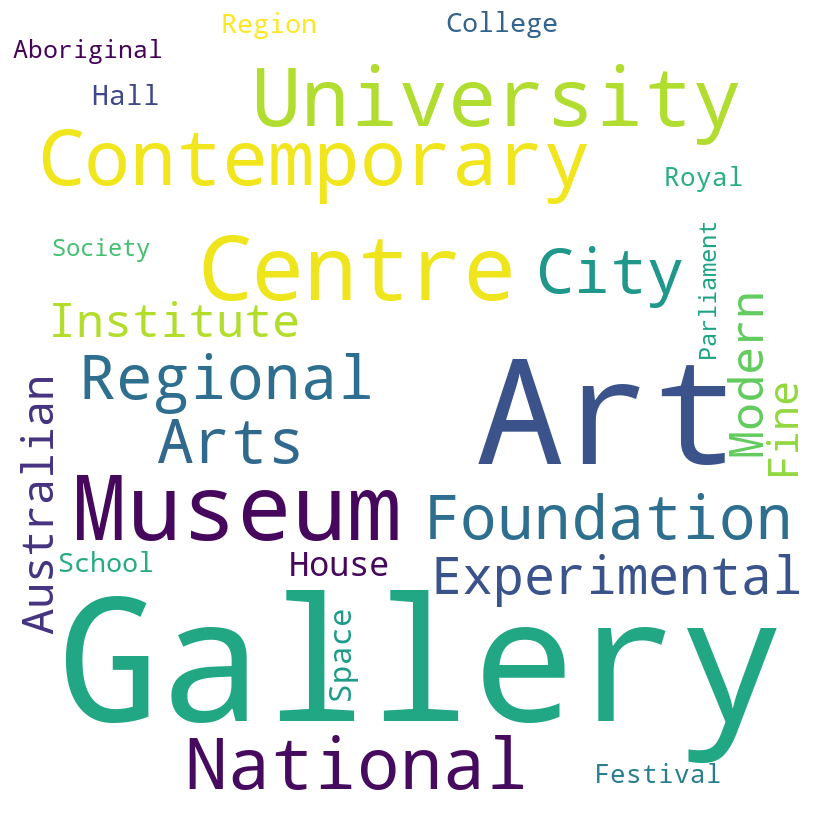

In [28]:
# find the most frequent words across the strings for place names
from collections import Counter
import matplotlib.pyplot as plt

import nltk
# nltk.download('punkt')

from nltk.tokenize import word_tokenize

# create a list of all the place names
all_place_names = df_daoo_relevant_events['place_name'].tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(100)

# remove a list of all words that are not relevant
words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
                   '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
                   'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
                   'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
                   'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
                   'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
                   '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
                   'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Place']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)

# add value of two keys
most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# remove key 'Gallery'
most_freq_words_dict.pop('Galleries')
most_freq_words_dict.pop('Museums')
most_freq_words_dict2 = most_freq_words_dict.copy()

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Hierarchical clustering using event description data 

Next we explore exhibition descriptions using hierarchical clustering; a method used to group similar objects into clusters that follow a hierarchical structure. This can help conceptualise what a taxonomy of venue categories might look like. We use two methods to embed the data, term frequency-inverse document frequency (TF-IDF) and Google's BERT.

The former is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. The latter is a language model that can embed a sense of "context" to the textual data. This means that the model can quantitatively encode the meaning of a word based on the words that surround it.

### Hierarchical clustering (tf-idf)

The first dendrogram shows the hierarchical clustering of the exhibition descriptions using TF-IDF. We cluster the data into seven groups. The x-axis provides a count (in brackets) of the exhibitition within each respective cluster. We also provide two sets of annotations. The annotations above the x-axis represent the most frequently occuring terms within the event description for each cluster. We limit this list to distinctive words. The annotations below the x-axis represent the most frequently occuring venues for each cluster.

In [59]:
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

### collect all relevant textual data from the dataframe
# replace '-' with ',' in the slug
df_daoo_relevant_events['slug2'] = df_daoo_relevant_events['slug'].str.replace('-',' ')

# if description is not \n then append to slug2 in one line
df_daoo_relevant_events['slug2'] = df_daoo_relevant_events['slug2'] + df_daoo_relevant_events['description'].apply(lambda x: '' if x == '\n' else x)

### pre-process for NLP
# Load the documents and their corresponding categorical variables into a Pandas dataframe
df = pd.DataFrame({'text': df_daoo_relevant_events['slug2'], 'category': df_daoo_relevant_events['place_name']})

# summarise text for each unique place name
df['text'] = df.groupby('category')['text'].transform(lambda x: ' '.join(x))

#add new column with count for each category
df['cat_count'] = df.groupby('category')['category'].transform('count')
df.drop_duplicates(inplace=True)

# Clean the text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.replace(',', '')
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Vectorize the text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])


### Generate clusters

def get_most_common_word(df, more_words = [], no_of_words=25):
    # remove a list of all words that are not relevant
    # words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
    #                 '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
    #                 'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
    #                 'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
    #                 'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
    #                 'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
    #                 '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
    #                 'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Place','Vic.',]
    
    words_to_remove = []
    
    # add more words to the list of words to remove
    words_to_remove = words_to_remove + more_words

    all_words = []
    for i in df:
        for j in i.split(' '):
            all_words.append(j.replace(',',''))

    # find the most common words
    most_common_words = Counter(all_words).most_common(no_of_words)

    # remove the words from the list of most frequent words
    most_common_words = [word for word in most_common_words if word[0] not in words_to_remove]
    return most_common_words

def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

# # setting distance_threshold=0 ensures we compute the full tree.
# model_tfidf = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_tfidf = model_tfidf.fit(X.toarray())

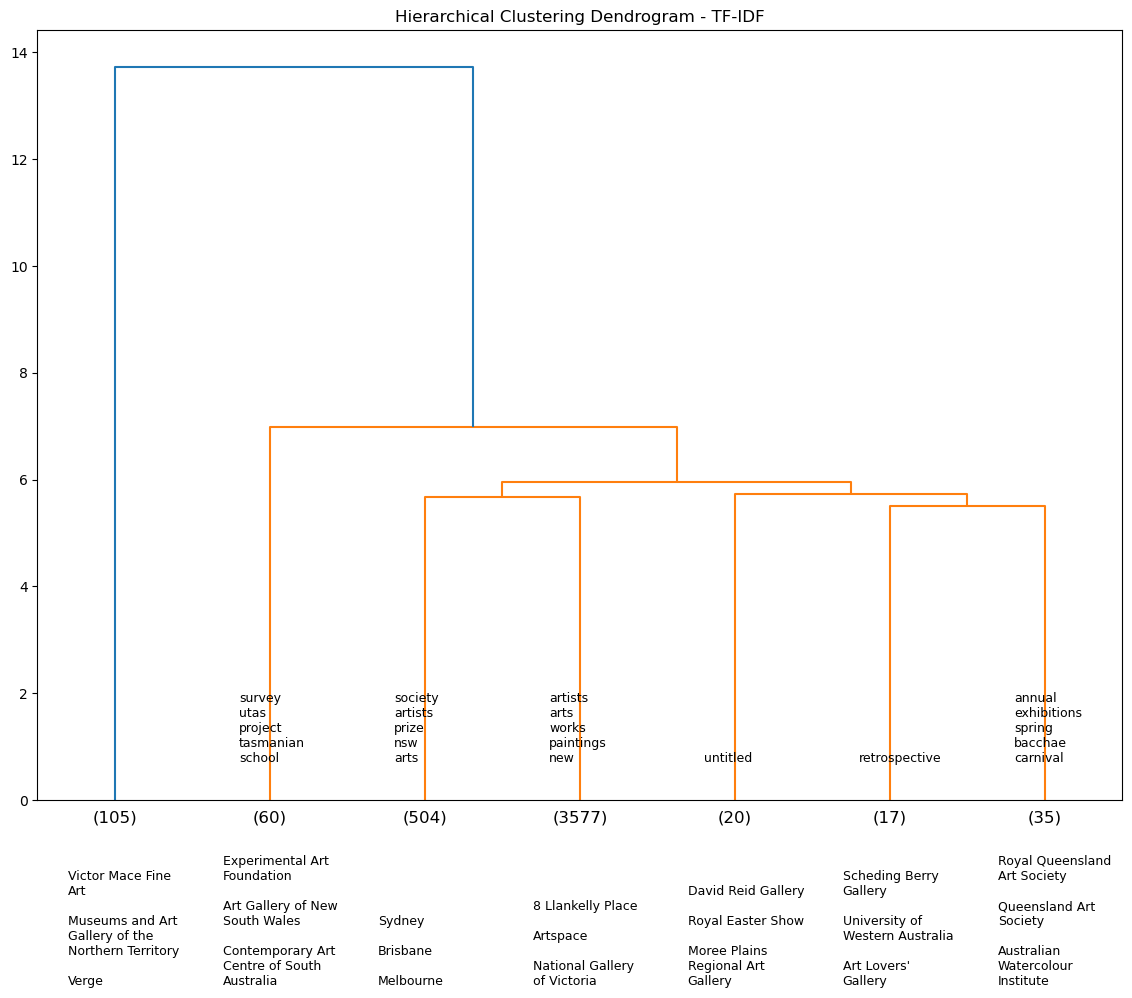

In [23]:
# from textwrap import wrap

# cut = 7
# l_matrix = get_linkage_matrix(model_tfidf)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# # if a word is a duplicate then remove from all_words
# def find_duplicates(all_words, occurences=1):
#     duplicates = []
#     non_duplicates = []

#     for i in all_words:
#         if i in duplicates: continue
#         else:
#             if all_words.count(i) > occurences: duplicates.append(i)
#             else: non_duplicates.append(i)
#     return duplicates

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','th','nd','exhibitionexhibited'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - TF-IDF")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output1.png')

We provide the same visual however show the most frequent terms used within the place names as opposed to the event descriptions.

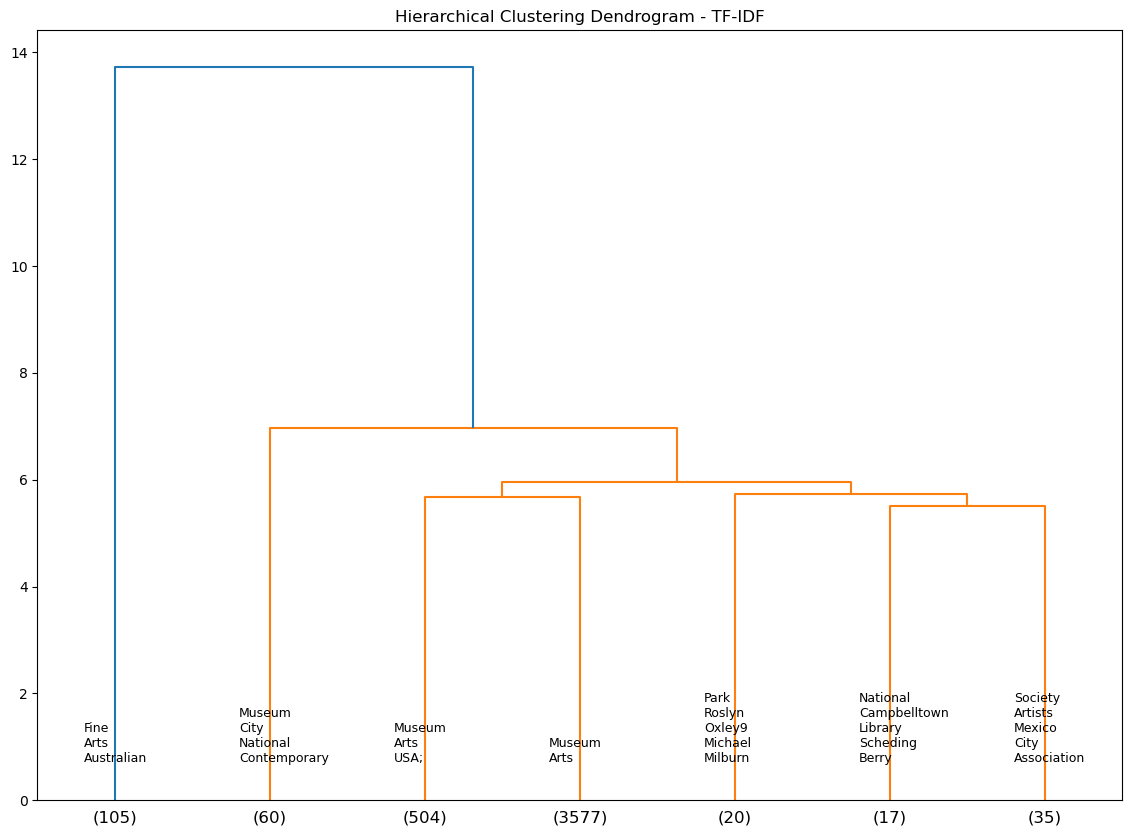

In [24]:
# cut = 7
# l_matrix = get_linkage_matrix(model_tfidf)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=3)

# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
#                    'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
#                    'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - TF-IDF")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output2.png')

### Hierarchical clustering (BERT)

We repeat the methodology but now change the embedding method to BERT. We expect using BERT, a much more complex model, to better represent each venue. We find that the clusters are more widely populated, and output a different outcome.

In [ ]:
# ### load bert model

# # !pip install transformers
# from transformers import BertTokenizer, BertModel
# from transformers import pipeline
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")
# # text = "Replace me by any text you'd like."
# # encoded_input = tokenizer(text, return_tensors='pt')
# # output = model(**encoded_input)
# # pd.DataFrame(output['pooler_output'].detach().numpy())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# ### encode text using bert (takes 4mins to run)
# import random

# # encode the text using bert
# def bert_encode(x):
#   encoded_input = tokenizer(x, return_tensors='pt')
#   output = model(**encoded_input)
#   return pd.DataFrame(output['pooler_output'].detach().numpy()).T

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df['clean_text_sampled'] = df['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 360)) if len(x.split(' ')) >= 360 else x)
# X_bert = df['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert = model_bert.fit(np.array(X_bert))

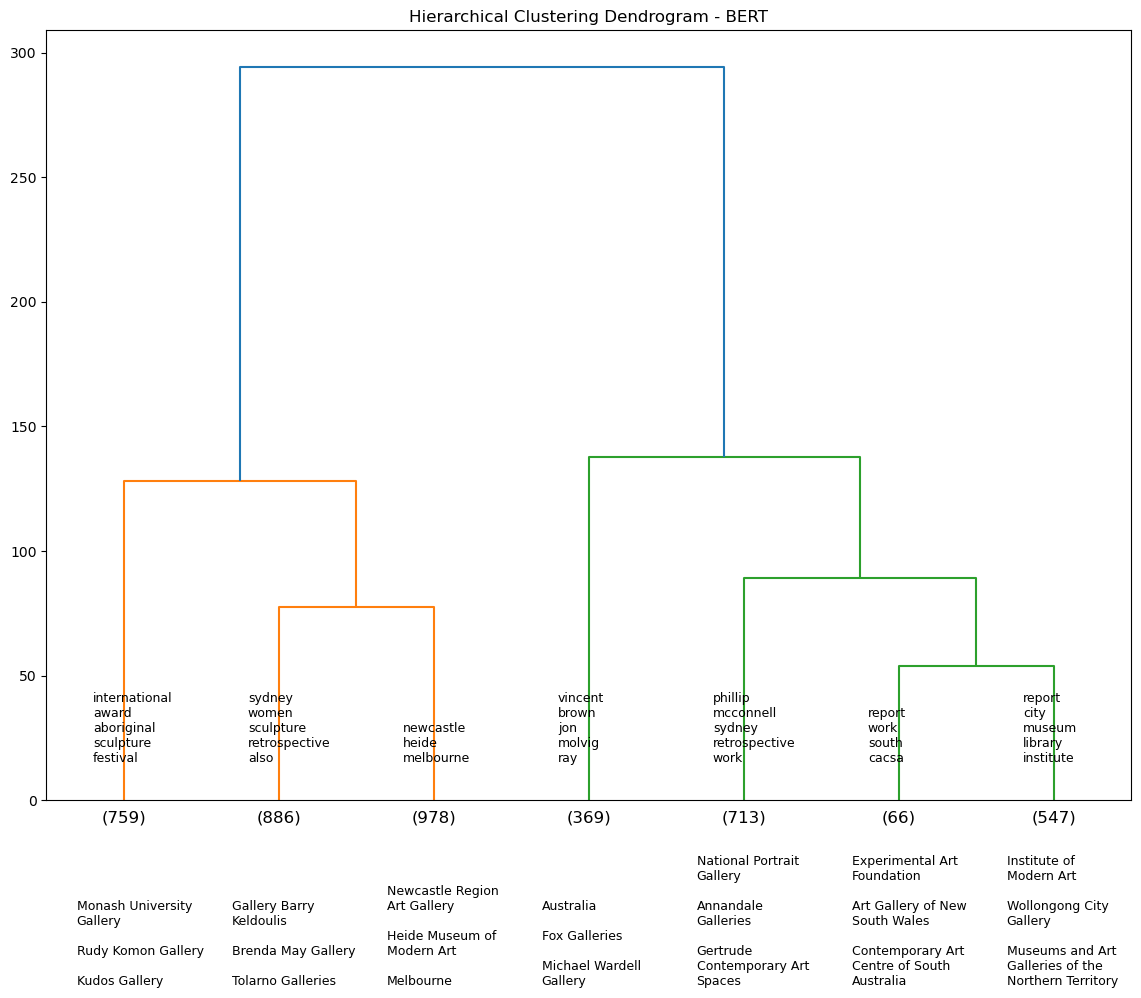

In [25]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output3.png')

We provide the same visual however show the most frequent terms used within the place names as opposed to the event descriptions.

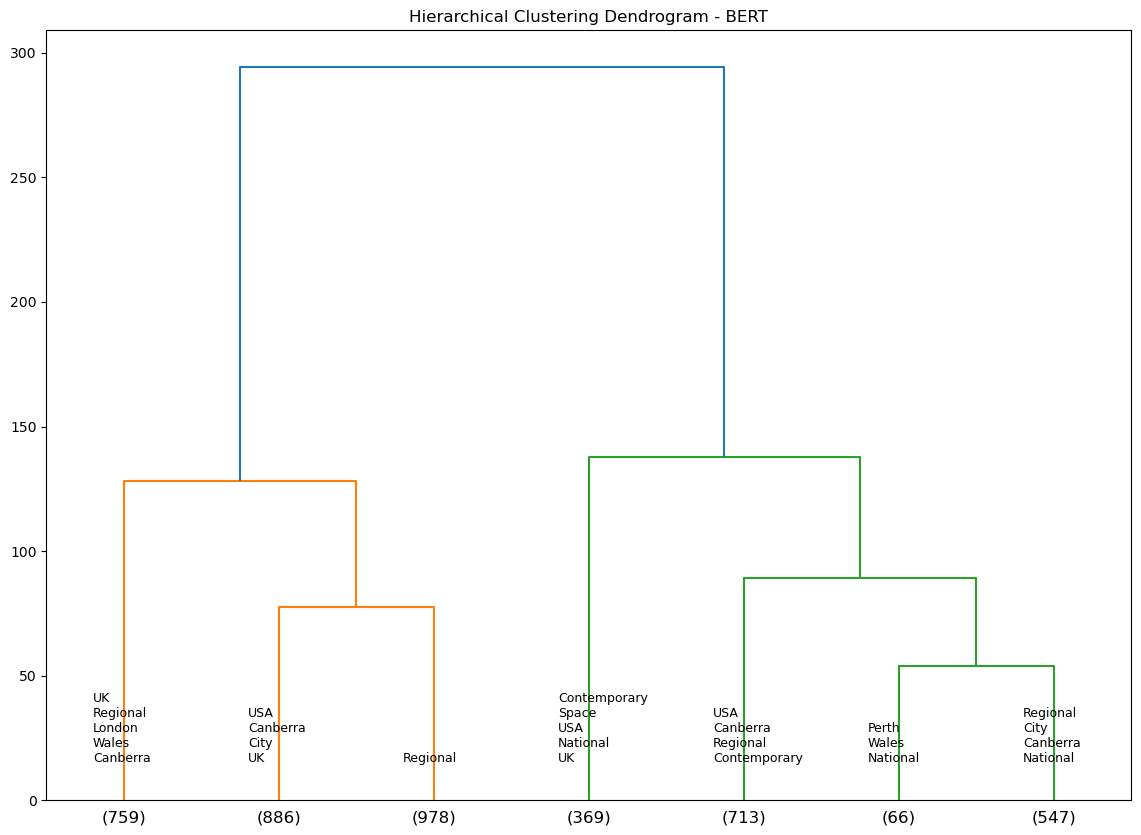

In [26]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=25))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=4)
# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'Australia', 'QLD', 'Vic','and','WA','Victoria','ACT','Qld',
#                    'of','Wollongong','TAS','Queensland','Newcastle',
#                    'Street','Hobart','the','The','Launceston','Orange','NT',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Heide',''])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output4.png')

### Hierarchical clustering (BERT) after omitting erroneous geocodes that occur frequently

In [ ]:
# # retrieve rows from most_freq_geocodes from a list of indices
# remove_these = most_freq_geocodes.head(20).iloc[~most_freq_geocodes.head(20).index.isin([4,5,6,8,9,13,14,15,16,18,19])]

# # remove 5656 rows from df_daoo_relevant_events with same lat and long data from remove_these 
# df_daoo_relevant_events['erroneous'] = np.where(df_daoo_relevant_events['latitude'].isin(remove_these['latitude']) &\
#                                                 df_daoo_relevant_events['longitude'].isin(remove_these['longitude']), True, False)

# ### pre-process for NLP
# # Load the documents and their corresponding categorical variables into a Pandas dataframe
# df2 = pd.DataFrame({'text': df_daoo_relevant_events[df_daoo_relevant_events['erroneous'] == 0]['slug2'], 
#                    'category': df_daoo_relevant_events[df_daoo_relevant_events['erroneous'] == 0]['place_name']})

# # summarise text for each unique place name
# df2['text'] = df2.groupby('category')['text'].transform(lambda x: ' '.join(x))

# #add new column with count for each category
# df2['cat_count'] = df2.groupby('category')['category'].transform('count')
# df2.drop_duplicates(inplace=True)

# # Clean the text
# stop_words = set(stopwords.words('english'))
# df2['clean_text'] = df2['text'].apply(clean_text)

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df2['clean_text_sampled'] = df2['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 320)) if len(x.split(' ')) >= 320 else x)
# X_bert2 = df2['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert2 = model_bert2.fit(np.array(X_bert2))

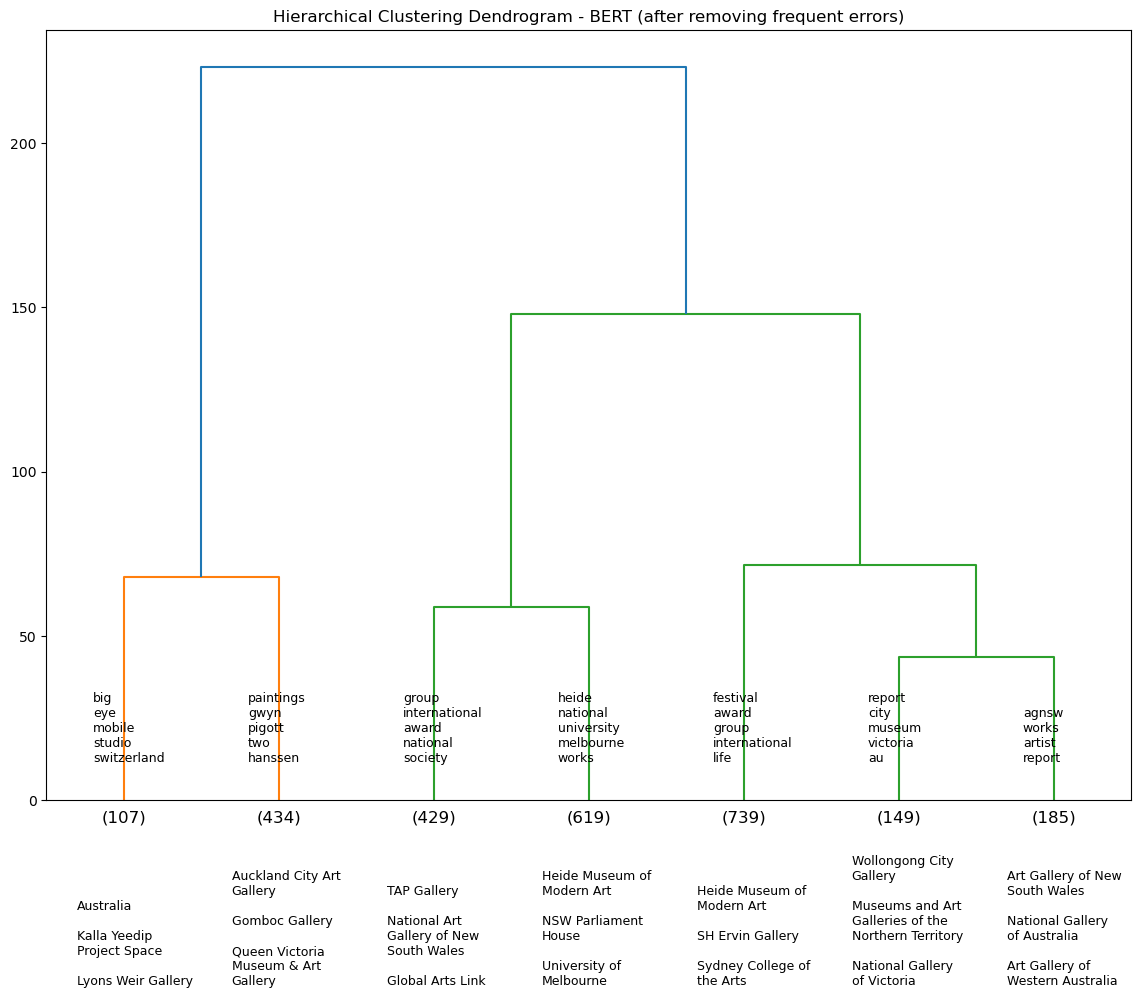

In [ ]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert2)
# df2['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','p','r','h','c','k','th','nd','exhibitionexhibited','isbn','http','www'])

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df2['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df2['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df2['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df2['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT (after removing frequent errors)")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

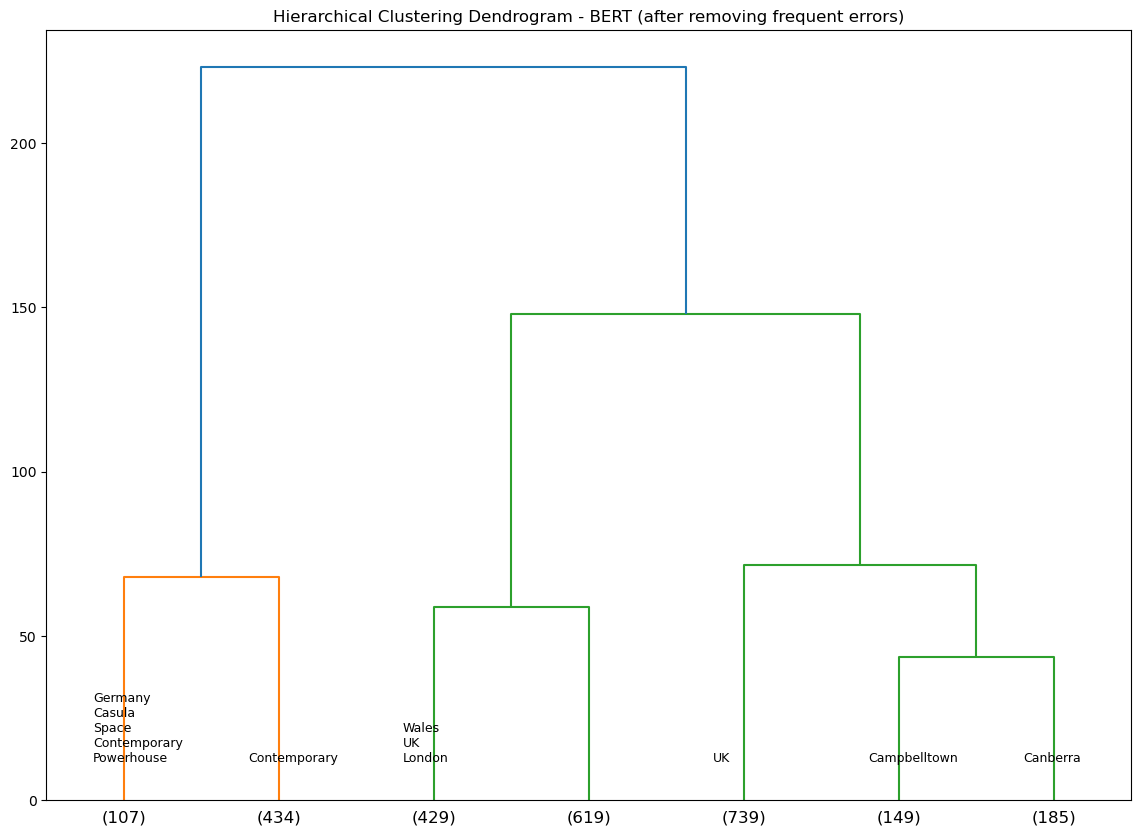

In [ ]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert2)
# df2['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=30))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=5)
# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'QLD', 'Vic','and','WA','Victoria','ACT','Qld',
#                    'of','Wollongong','TAS','Queensland','Newcastle','Australia',
#                    'Street','Hobart','the','The','Launceston','Orange','NT',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Heide',''])

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 20))
    
#     plt.annotate(annot, xy=(i/df2['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df2['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT (after removing frequent errors)")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

## Organisations
Similar to venues, we first produce a word cloud for common terms used in organisation names. We find that the most frequent terms are "Society", "Art", "Gallery", "Royal", and "Arts".

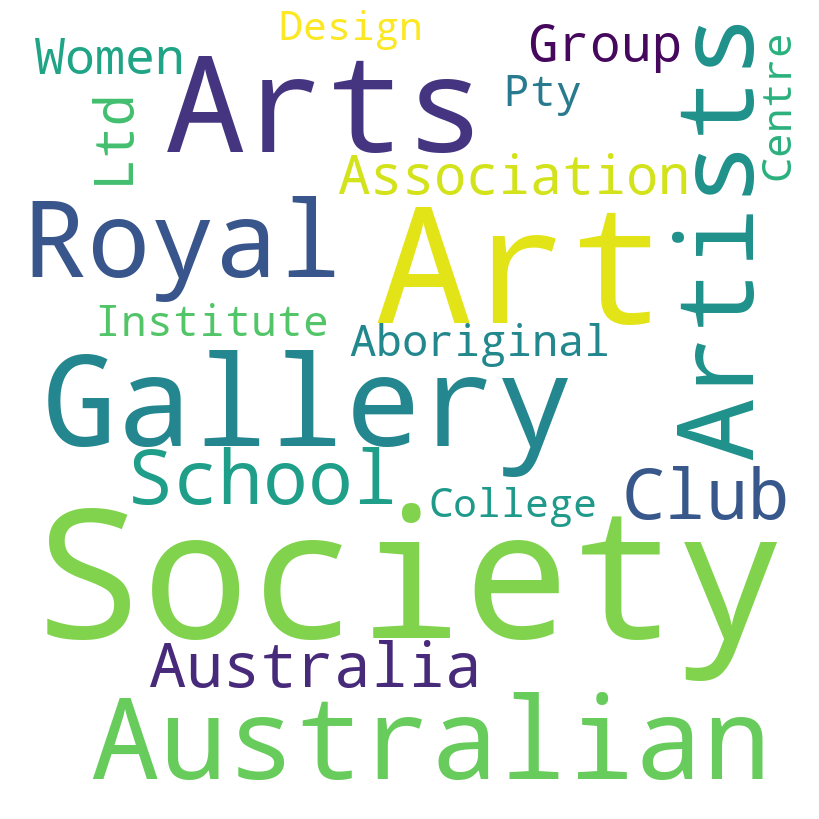

In [ ]:
# bios = pd.read_csv('data/daao_biography_level_202202211719.csv')
# bios = bios[['_id','primary_name.family_name','primary_name.given_names']]
# bios[bios['_id'].str.contains('4e1e1424b846f2dae7001dc0')]

with open("data/daao_persongroup_level.json") as json_file: daoo_org_data=json.load(json_file)

# create a list of all the place names
all_place_names = pd.json_normalize(daoo_org_data)['primary_name'].astype(str).tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(40)

# remove a list of all words that are not relevant
words_to_remove = [',','.','and','of','the','The','for',"'s",'&','(',')','J.','Melbourne',
                   'UK','VIC','London',
                   'Jane','Lapham','*','Adelaide',"'",'Sydney','NSW','New','South','Wales']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)

# # add value of two keys
# most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
# most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# # remove key 'Gallery'
# most_freq_words_dict.pop('Galleries')
# most_freq_words_dict.pop('Museums')

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

As shown above, the use of dendrograms can be an interesting exercise to explore the data. The initial idea was to repeat the same approach with organisations to assess any latent patterns through this taxonomic approrach. However, we find that the data is not as rich as the venue data and that there are many organisations with no biographies, no summaries, and no relations to people records, exhibition records, etc.  Nevertheless we provide one dendrogram using organisation biographies.

Below is a list of the proportion of missing data for each field across DAAO organisations.

In [ ]:
# find the proportion of null values in each column
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[0:20])

biography              0.869957
_cls                   0.000000
editing_complete       0.922318
is_deleted             0.000000
is_featured            0.000000
is_locked              0.000000
is_primary             0.000000
is_shadow              0.000000
primary_name           0.000858
periods_active         0.959227
record_status          0.000000
residences             0.959442
roles                  0.000000
sources                0.913519
slug                   0.000000
summary                0.917167
related_stub_people    0.998927
_id.$oid               0.000000
date_created.$date     0.024678
date_modified.$date    0.069528
dtype: float64

In [ ]:
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[20:])

references                    0.896567
tags                          0.962017
type                          0.974464
types                         0.965665
related_events                0.972318
related_collections           0.985837
related_works                 0.922318
related_recognitions          0.996996
related_stub_person_groups    0.998927
copyright_agents              0.999571
urls                          0.896137
alternative_names             0.967811
locked_biographies            0.999356
other_occupations             0.996996
see_alsos                     0.982833
nla_id                        0.999356
source_database_ids           0.985837
dtype: float64


In [ ]:
# from bs4 import BeautifulSoup

# orgs = pd.DataFrame(columns=['name','summary','bio'])

# # pd.json_normalize(daoo_org_data)['biography'].isnull().sum()/pd.json_normalize(daoo_org_data).shape[0] # 87% of rows have no biography

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try:
#         try: row['biography'][0]['text']
#         except: continue

#         # try: period_start = row['periods_active'][0]['start']['_date']
#         # except: period_start = None

#         # try: period_end = row['periods_active'][0]['end']['_date']
#         # except: period_end = None

#         # use pandas.concat to append new row to dataframe
#         orgs = pd.concat([orgs, pd.DataFrame({'name': [row['primary_name']],
#                                                 'summary': [row['summary']],
#                                                 'bio': [row['biography'][0]['text']],
#                                                 # 'period_start': [period_start],
#                                                 # 'period_end': [period_end]
#                                                 })], ignore_index=True)
        
#     except:
#         print(i)
#         break

# # remove empty summary
# orgs['summary'].fillna('', inplace=True)

# # remove rows with stub text
# orgs = orgs[~orgs['bio'].isin(orgs['bio'].value_counts().head(5).index.to_list())]

# # combine summary and bio
# orgs['bio'] = orgs['summary'] + orgs['bio'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

# orgs = orgs[['name','bio']]

In [ ]:
# ### encode text using bert (takes 4mins to run)

# ### pre-process for NLP
# # Load the documents and their corresponding categorical variables into a Pandas dataframe
# df_org = pd.DataFrame({'text': orgs['bio'], 'category': orgs['name']})

# #add new column with count for each category
# df_org['cat_count'] = df_org.groupby('category')['category'].transform('count')
# df_org.drop_duplicates(inplace=True)

# # Clean the text
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     text = re.sub('[^a-zA-Z]', ' ', text)
#     text = text.replace(',', '')
#     text = text.lower().split()
#     text = [word for word in text if word not in stop_words]
#     text = ' '.join(text)
#     return text

# df_org['clean_text'] = df_org['text'].apply(clean_text)

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df_org['clean_text_sampled'] = df_org['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 350)) if len(x.split(' ')) >= 350 else x)
# X_bert_org = df_org['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert_org = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert_org = model_bert_org.fit(np.array(X_bert_org))

Biographical data for each organisation (~130 organisations) is used to create the clusters. From here we show the most common terms used in the organisation name for each cluster.

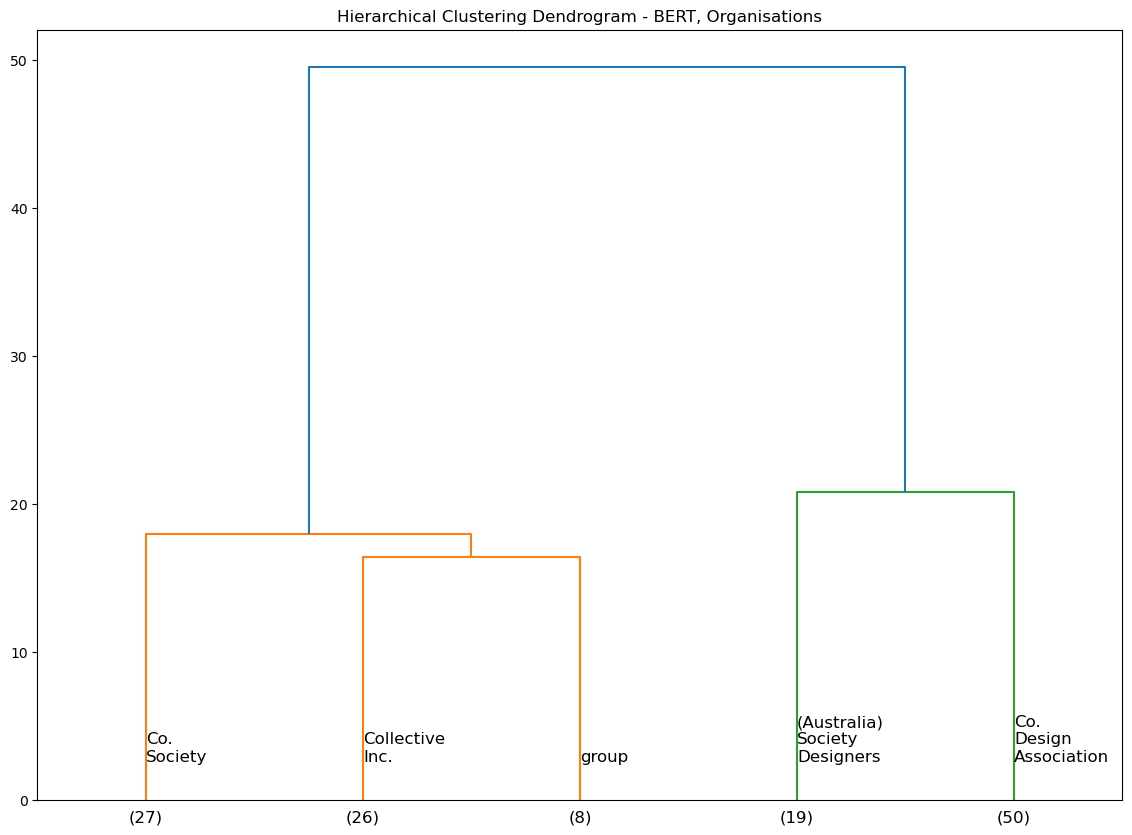

In [ ]:
# cut = 5
# l_matrix = get_linkage_matrix(model_bert_org)
# df_org['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=5))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=4)
# all_words_to_remove.extend(['h','co','e','test','Lapham','J.','Jane','','and','of','&','The','SymbioticA','Nevin','Smith'])

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=6,
#                                                                        more_words=all_words_to_remove)) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=12)
    
#     # annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     # annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     # plt.annotate(annot2, xy=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xytext=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT, Organisations")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output5.png')

In [ ]:
# with open("data/daao_relation.json") as json_file: daao_relation_data=json.load(json_file)
# relation_df = pd.json_normalize(daao_relation_data)
# print(relation_df[((relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person'))]['obj._ref.$id.$oid'].shape)

# with open("data/daao_xparty.json") as json_file: daao_xparty_data=json.load(json_file)
# xparty_df = pd.json_normalize(daao_xparty_data)
# xparty_df.head()

# xparty_df[xparty_df['_cls']=='VersionedDocument.XParty.PersonGroup']['primary_name'].value_counts()

# org_df = pd.json_normalize(daoo_org_data)
# org_df[org_df['_id.$oid'].isin(relation_df[(relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person')]['obj._ref.$id.$oid'])]

# orgs_ppl = pd.DataFrame()

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try: 
#         related_people = []
#         for j,row2 in pd.json_normalize(row['related_stub_people']).iterrows():
#             related_people.extend([pd.json_normalize(row2['predicate'])['_id.$oid'].values[0], 
#                                 pd.json_normalize(row2['target'])['_id.$oid'].values[0]])

#         ppl = pd.DataFrame({'related_people':list(dict.fromkeys(related_people))})
#         ppl['organisation'] = row['primary_name']
#         orgs_ppl = pd.concat([orgs_ppl, ppl], ignore_index=True)
#     except: continue

## Temporal analysis of venues

To further explore frequently used terms in place names, we produce an interactive time series of the number of events per decade by associated terms.

Before the visuals, we provide an ordered list of the decades with the most event activity, and also a list of the top 20 most frequent terms used in place names.

In [30]:
events_df = df_daoo_relevant_events.copy()

# create a new column with the decade of start year
events_df['decade'] = events_df['start_year'].apply(lambda x: str(x)[:3] + '0')
events_df['decade'] = events_df['decade'].apply(lambda x: '2000' if x == '2020' else x)
events_df['decade'] = events_df['decade'].astype(int)
events_df['decade'].value_counts()

2000    4332
1990    3312
1980    1909
1970     831
2010     527
1960     309
1930     265
1900     241
1920     239
1950     227
1940     201
1910     148
Name: decade, dtype: int64

In [31]:
most_freq_words_dict2

{'Gallery': 6202,
 'Art': 4286,
 'Centre': 975,
 'Museum': 1028,
 'University': 791,
 'Contemporary': 732,
 'National': 609,
 'City': 456,
 'Regional': 447,
 'Arts': 447,
 'Foundation': 441,
 'Experimental': 434,
 'Modern': 346,
 'Institute': 339,
 'Australian': 300,
 'Fine': 273,
 'House': 169,
 'Space': 139,
 'Hall': 110,
 'School': 105,
 'Region': 103,
 'College': 101,
 'Festival': 96,
 'Royal': 93,
 'Aboriginal': 89,
 'Parliament': 85,
 'Society': 83}

In [32]:
words_by_decade = pd.DataFrame()

for key in most_freq_words_dict2:
    words_this_decade = events_df[events_df['place_name'].str.contains(key)]\
                        .groupby('decade')['place_name']\
                        .count()\
                        .reset_index(name='count')\
                        .sort_values(['decade'], ascending=True)
    words_this_decade['term'] = key
    words_by_decade = pd.concat([words_by_decade, words_this_decade], ignore_index=True)

In [33]:
import plotly.express as px
fig = px.line(words_by_decade, x="decade", y="count", color='term',
                title='Count of each term by decade')

# # make figure size bigger
# # fig.update_layout(
# #     autosize=False,
# #     width=700,
# #     height=500,
# # )

fig.show()

In [34]:
# events_df['diff'] = events_df['end_year'] - events_df['start_year']
# # events_df[(events_df['place_name'].str.contains('Contemporary')) & (events_df['diff'] > 1)]

# using start_date, end_date, place_name, calculate the difference between start_date of the first event in an venue and end_date of the last event in that venue
places_with_start_end = []
[places_with_start_end.extend([p, events_df.loc[events_df['place_name'] == p, 'start_year'].min(), 
                              events_df.loc[events_df['place_name'] == p, 'end_year'].max()] for p in events_df['place_name'].unique())]

places_with_start_end = pd.DataFrame(places_with_start_end)
places_with_start_end.columns = ['place_name', 'start_year', 'end_year']
places_with_start_end['diff'] = places_with_start_end['end_year'] - places_with_start_end['start_year']
places_with_start_end = places_with_start_end[places_with_start_end['diff'] >= 0]
# places_with_start_end.sort_values('diff', ascending=False)

Beyond the above time series, we also provide a series of bar charts, however instead of illustrating event activity within a certain decade, we plot the number of venues active across time. We calculate the start and end of a venue's "lifespan" by using the earliest and latest event date associated with a venue. We do this by filtering on venues with associated terms in the place name.

Most bar charts follow the same upwards trends shown in the above time series, however some terms that highlight some different trajectories consist of "contemporary", "society", "experimental" and "space".

In [35]:
decade_placeholder = pd.DataFrame([0] * 13, index=range(1900, 2020+1, 10)).reset_index().rename(columns={'index':'decade', 0:'count'})
decade_placeholder['decade'] = decade_placeholder['decade'].astype(str)

for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['place_name'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(row['start_year'], row['end_year']+1): 
            contemporary_wide.loc[row['place_name'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'place_name'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder, on='decade', how='outer')
    contemporary_wide['count'] = contemporary_wide['count_x'] + contemporary_wide['count_y']
    contemporary_wide = contemporary_wide[['decade', 'count']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='count',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()

### Proportions
We repeat the same temporal visuals as above, however this time we plot the proportions to effectively normalise the data with respect to the number of events across decades, and the number of venues that existed across time, repsectively.

Note that the y-axis limits in the bar charts changes for each term.

In [36]:
words_by_decade_prop = []

# find the proportions of each word in each decade
for i in most_freq_words_dict2.keys():
    for j in events_df['decade'].unique():
        prop = events_df[(events_df['place_name'].str.contains(i)) & (events_df['decade'] == j)].shape[0] /events_df[events_df['decade'] == j].shape[0]
        words_by_decade_prop.append([i,j,prop])
    
words_by_decade_prop = pd.DataFrame(words_by_decade_prop)
words_by_decade_prop.columns = ['word','decade','proportion']

In [37]:
# plot proportion of each term by decade
# make it interactive

import plotly.express as px

fig = px.line(words_by_decade_prop.sort_values('decade'), x="decade", y="proportion", color='word',
                title='Proportion of each term by decade')

# make figure size bigger
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=500,
# )

fig.show()

In [38]:
allplaces_wide = pd.DataFrame()

for i,row in places_with_start_end.iterrows():
    for year in range(row['start_year'], row['end_year']+1): 
        allplaces_wide.loc[row['place_name'], str(year)[:3] + '0'] = 1

decade_placeholder_forprop = allplaces_wide.\
                            fillna(0).\
                            reset_index().\
                            rename(columns={'index':'place_name'}).\
                            sum().tail(-1).\
                            reset_index().\
                            rename(columns={'index':'decade', 0:'count'}).\
                            sort_values('decade', ascending=True)

In [39]:
for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['place_name'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(row['start_year'], row['end_year']+1): 
            contemporary_wide.loc[row['place_name'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'place_name'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder_forprop, on='decade', how='outer')
    contemporary_wide['prop'] = np.where(contemporary_wide['count_x'] > 0, 
                                     contemporary_wide['count_x']/contemporary_wide['count_y'], 0)
    contemporary_wide = contemporary_wide[['decade', 'prop']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='prop',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()